In [ ]:
#Import the needed dependincies
import os
from PIL import Image

import matplotlib.pyplot as plt
import shutil
import numpy as np
import cv2
from skimage import io, exposure
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dropout, Dense
import tensorflow as tf
from keras.models import save_model
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the name of our new directory
IMAGE_DIR='images'
# Set the path where we want to create the new directory
path = "/content/drive/My Drive/" + IMAGE_DIR
# Create the directory
os.makedirs(path, exist_ok=True)

In [ ]:
#Place all digit images in one folder
new_dir = '/content/drive/MyDrive/images'
for i in range(0,10):
  current_dir = f'/content/drive/MyDrive/freelance/OCR_Task_Digits_Dataset/dataset/{i}'
  for filename in os.listdir(current_dir):
      if filename.endswith('.png'):
          old_path = os.path.join(current_dir, filename)
          new_path = os.path.join(new_dir, filename)
          shutil.move(old_path, new_path)

In [ ]:
#Labeling our images
dir_path = new_dir
file_names = os.listdir(dir_path)
label_dict = {}
for file_name in file_names:
    if file_name.endswith('.png'):
        label = file_name.split('_')[0]
        label_dict[file_name] = label

In [ ]:
#Resize Images and convert each image  to np.array
img_size = (28, 28)
images = []
labels = []

for file_name in file_names:
    if file_name.endswith('.png'):
        file_path = os.path.join(dir_path, file_name)
        image = Image.open(file_path)
        image = image.resize(img_size)
        image = np.array(image)
        images.append(image)
        #listing our labels
        labels.append(label_dict[file_name])

In [ ]:
#Convert labels from str to  integers
label=[]
for l in labels:
  label.append(int(l))
#convert images and labels lists to np.array
images = np.array(images)
label = np.array(label)

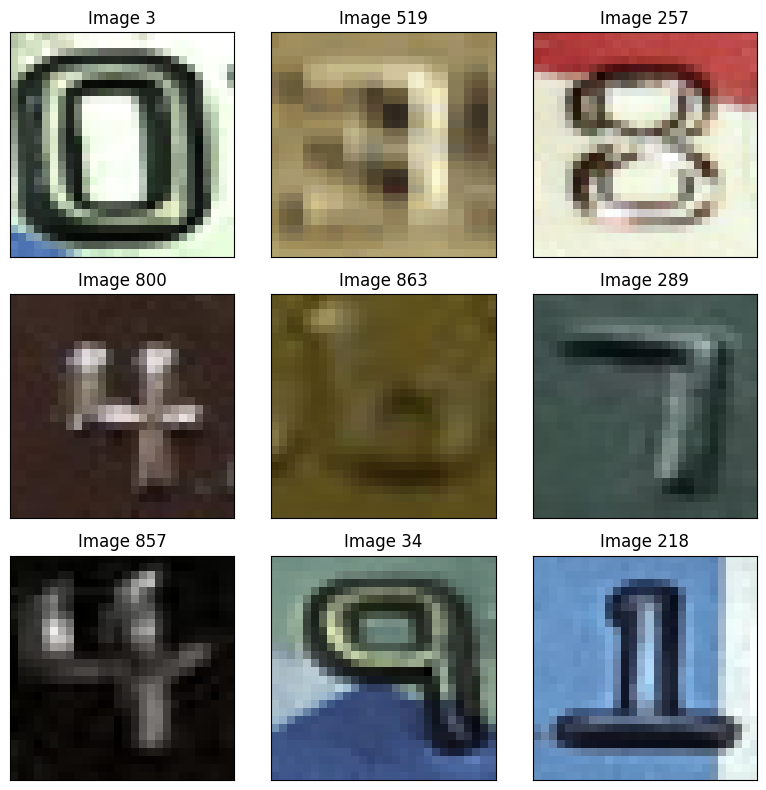

Image 3 Label 0
Image 519 Label 3
Image 257 Label 8
Image 800 Label 4
Image 863 Label 6
Image 289 Label 7
Image 857 Label 4
Image 34 Label 9
Image 218 Label 1


In [ ]:
#take random 9 images indices from our dataset
indices = np.random.choice(range(len(images)), replace=False, size=9)
selected_images = images[indices]
#plot the 9 images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])
    ax.set_title(f"Image {indices[i]}")

plt.tight_layout()
plt.show()
#Print the labels of the images sample
for i in indices:
  print('Image',i ,'Label',label[i])

PreProcessing

In [ ]:
# Convert the BGRA images to grayscale and save them in a list 
Gray_Images=[]
for img in images:
  bgra_img=img
  gray_img = cv2.cvtColor(bgra_img, cv2.COLOR_BGRA2GRAY)
  Gray_Images.append(gray_img)

In [ ]:
#Image Normalization
Normalized_Images=[]
for img in Gray_Images :
# Normalize the pixel valuesfrom the range[0,255] to the range [0, 1] using min-max scaling
  normalized_img = exposure.rescale_intensity(img, in_range=(0, 255), out_range=(0, 1))
  Normalized_Images.append(normalized_img)


In [ ]:
#Contrast Enhancement
Enhanced_Images=[]
# Load the image as a NumPy array
for img in Normalized_Images:
  # Apply contrast stretching to enhance the contrast of the image between percentiles (10,90)
  p10, p90 = np.percentile(img, (10, 90))
  enhanced_img = exposure.rescale_intensity(img, in_range=(p10, p90))
  Enhanced_Images.append(enhanced_img)


In [ ]:
# Image Binarization 
Binarized_Images=[]
for img in Enhanced_Images:
  # Binarize the image using a threshold value of 100
  threshold_value = 0.45
  max_value = 1
  binarized_img = np.where(img < threshold_value, 0, max_value)
  Binarized_Images.append(binarized_img)
#Convert to np.array
Binarized_Images=np.array(Binarized_Images)

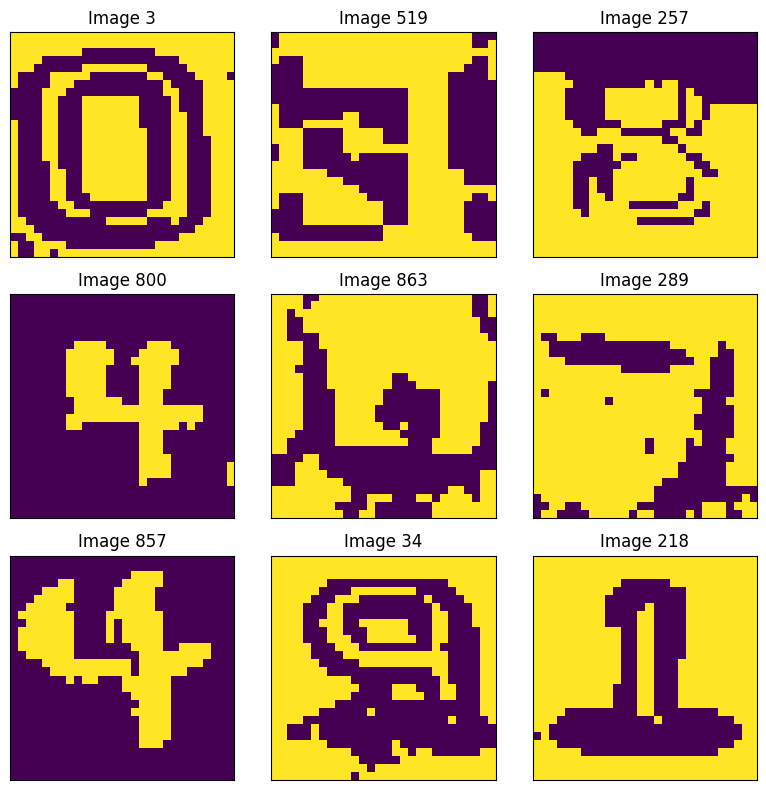

Image 3 Label 0
Image 519 Label 3
Image 257 Label 8
Image 800 Label 4
Image 863 Label 6
Image 289 Label 7
Image 857 Label 4
Image 34 Label 9
Image 218 Label 1


In [ ]:
#View Random sample of our dataset after preprocessing 
selected_imgs=Binarized_Images[indices]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_imgs[i])
    ax.set_title(f"Image {indices[i]}")

plt.tight_layout()
plt.show()
#Print the correct labels for the images of the sample
for i in indices:
  print('Image',i ,'Label',label[i])

In [ ]:
#Split the images and labels to train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(Binarized_Images, label, test_size=0.2, random_state=42)


In [ ]:
#reshape train and test sets 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) /1.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) /1.0

In [ ]:
#Create the CNN Model

model = Sequential()
model.add(Conv2D(32, (3, 3),strides=(1, 1), padding='same',activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(train_images, train_labels, epochs=15)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/15
22/22 [==============================] - 3s 5ms/step - loss: 2.2975 - accuracy: 0.1110
Epoch 2/15
22/22 [==============================] - 0s 5ms/step - loss: 2.2537 - accuracy: 0.1664
Epoch 3/15
22/22 [==============================] - 0s 5ms/step - loss: 2.1448 - accuracy: 0.2774
Epoch 4/15
22/22 [==============================] - 0s 5ms/step - loss: 1.6257 - accuracy: 0.4964
Epoch 5/15
22/22 [==============================] - 0s 5ms/step - loss: 0.9723 - accuracy: 0.6885
Epoch 6/15
22/22 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.7639
Epoch 7/15
22/22 [==============================] - 0s 5ms/step - loss: 0.5634 - accuracy: 0.8165
Epoch 8/15
22/22 [==============================] - 0s 5ms/step - loss: 0.4708 - accuracy: 0.8563
Epoch 9/15
22/22 [==============================] - 0s 5ms/step - loss: 0.4107 - accuracy: 0.8706
Epoch 10/15
22/22 [==============================] - 0s 4ms/step - loss: 0.3853 - accuracy: 0.8762
Epoch 11/15
22/22 [

In [ ]:
save_model(model,'DigitOCR.h5')

This Image Label is :   1


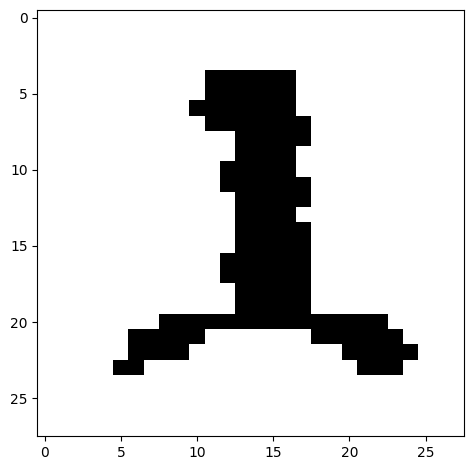

In [ ]:
#take a random sample of test set
indices = np.random.choice(range(len(test_images)), replace=False, size=10)
#View an image and its label from test set
io.imshow(test_images[indices[0]]/1.0)
print('This Image Label is :  ',test_labels[indices[0]])

In [ ]:
#create list for the predicted labels of test set 
y_preds=model.predict(test_images,verbose=0)
y_labels=[np.argmax(i) for i in y_preds]

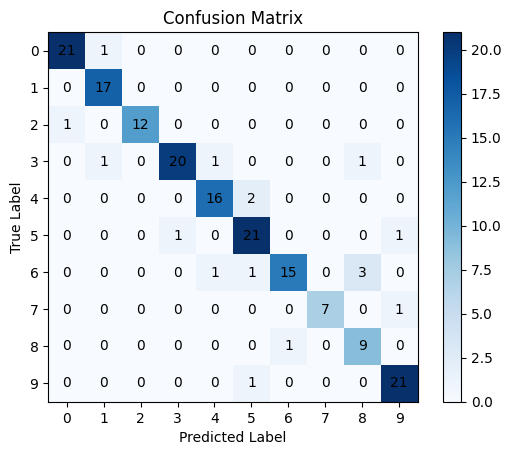

In [ ]:
#Create Confusion matrix for the test results
cm = confusion_matrix(test_labels, y_labels)
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the label counts to the cells of the confusion matrix
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')

plt.show()

In [ ]:
#Create a classification report
from sklearn import metrics
print (metrics.classification_report(test_labels,y_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.89      1.00      0.94        17
           2       1.00      0.92      0.96        13
           3       0.95      0.87      0.91        23
           4       0.89      0.89      0.89        18
           5       0.84      0.91      0.87        23
           6       0.94      0.75      0.83        20
           7       1.00      0.88      0.93         8
           8       0.69      0.90      0.78        10
           9       0.91      0.95      0.93        22

    accuracy                           0.90       176
   macro avg       0.91      0.90      0.90       176
weighted avg       0.91      0.90      0.90       176

